In [3]:
from cortexlib.utils.plotting import simclr_colours, vgg19_colours, neural_colour
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import to_rgb
from pathlib import Path
import pandas as pd
import numpy as np
import json


paths = [
    Path("../../../analysis/mouse_m01_d2/03_simclr_neural/explained_variance_full_dim.json"),
    Path("../../../analysis/mouse_m01_d2/05_vgg19_neural/explained_variance_full_dim.json"),
    Path("../../../analysis/mouse_m02_d3/03_simclr_neural/explained_variance_full_dim.json"),
    Path("../../../analysis/mouse_m02_d3/05_vgg19_neural/explained_variance_full_dim.json"),
    Path("../../../analysis/mouse_m03_d4/03_simclr_neural/explained_variance_full_dim.json"),
    Path("../../../analysis/mouse_m03_d4/05_vgg19_neural/explained_variance_full_dim.json"),
]

all_data = []
for path in paths:
    with open(path, "r") as f:
        data = json.load(f)
        all_data.extend(data)

records = []

for entry in all_data:
    mouse_id = entry['mouse_id']
    model = entry['model'].lower()
    layer = entry['layer']
    dims = entry['original_dimensions']

    pcs_68 = entry['num_principal_components_68pc_ev']
    mean_pc_68 = np.mean(pcs_68)
    percent_pc_68 = (mean_pc_68 / dims) * 100

    records.append({
        'mouse_id': mouse_id,
        'model': model,
        'layer': layer,
        'original_dimensions': dims,
        'num_principal_components_68pc_ev': pcs_68,
        'pc_percent_68': percent_pc_68
    })

ev_df = pd.DataFrame(records)
ev_df.head(50)

,mouse_id,model,layer,original_dimensions,num_principal_components_68pc_ev,pc_percent_68
0,m01_d2,simclr,layer1,36864,452,1.226128
1,m01_d2,simclr,layer2,18432,333,1.806641
2,m01_d2,simclr,layer3,9216,199,2.159288
3,m01_d2,simclr,layer4,4608,109,2.365451
4,m01_d2,simclr,fc,512,28,5.468750
5,m01_d2,vgg19,conv2_2,128,2,1.562500
6,m01_d2,vgg19,conv3_4,256,1,0.390625
7,m01_d2,vgg19,conv4_4,512,1,0.195312
8,m01_d2,vgg19,conv5_4,512,4,0.781250
9,m01_d2,vgg19,fc2,4096,7,0.170898


In [5]:
summary = (
    ev_df.groupby(['model', 'layer'])
      .agg(mean=('pc_percent_68', 'mean'),
           sem=('pc_percent_68', lambda x: x.std(ddof=1) / np.sqrt(len(x))))
      .reset_index()
)
summary.head(20)

,model,layer,mean,sem
0,simclr,fc,5.468750,0.000000
1,simclr,layer1,1.299371,0.036696
2,simclr,layer2,1.884404,0.038913
3,simclr,layer3,2.213542,0.027307
4,simclr,layer4,2.394387,0.014468
5,vgg19,conv2_2,1.302083,0.260417
6,vgg19,conv3_4,0.390625,0.000000
7,vgg19,conv4_4,0.195312,0.000000
8,vgg19,conv5_4,0.781250,0.000000
9,vgg19,fc2,0.170898,0.000000


In [6]:
# Neural results
paths = [
    Path("../../../analysis/mouse_m01_d2/03_simclr_neural/neural_explained_variance_full_dim.json"),
    Path("../../../analysis/mouse_m02_d3/03_simclr_neural/neural_explained_variance_full_dim.json"),
    Path("../../../analysis/mouse_m03_d4/03_simclr_neural/neural_explained_variance_full_dim.json"),
]

neural_data = []
for path in paths:
    with open(path, "r") as f:
        data = json.load(f)
        neural_data.append(data)

neural_records = []

for entry in neural_data:
    mouse_id = entry['mouse_id']
    model = entry['model'].lower()
    layer = entry['layer']
    dims = entry['original_dimensions']

    pcs_68 = entry['num_principal_components_68pc_ev']
    mean_pc_68 = np.mean(pcs_68)
    percent_pc_68 = (mean_pc_68 / dims) * 100

    neural_records.append({
        'mouse_id': mouse_id,
        'pc_percent_68': percent_pc_68,
    })

neural_ev_df = pd.DataFrame(neural_records)
neural_ev_df.head(50)

,mouse_id,pc_percent_68
0,m01_d2,23.8
1,m02_d3,28.0
2,m03_d4,27.4


In [7]:
neural_mean = neural_ev_df['pc_percent_68'].mean()
neural_sem = neural_ev_df['pc_percent_68'].std(ddof=1) / np.sqrt(len(neural_ev_df))

neural_row = pd.DataFrame([{
    'layer': 'neural',
    'mean': neural_mean,
    'sem': neural_sem,
    'model': 'neural',
}])

summary_with_neural = pd.concat([summary, neural_row], ignore_index=True)
summary_with_neural.head(20)

,model,layer,mean,sem
0,simclr,fc,5.468750,0.000000
1,simclr,layer1,1.299371,0.036696
2,simclr,layer2,1.884404,0.038913
3,simclr,layer3,2.213542,0.027307
4,simclr,layer4,2.394387,0.014468
5,vgg19,conv2_2,1.302083,0.260417
6,vgg19,conv3_4,0.390625,0.000000
7,vgg19,conv4_4,0.195312,0.000000
8,vgg19,conv5_4,0.781250,0.000000
9,vgg19,fc2,0.170898,0.000000


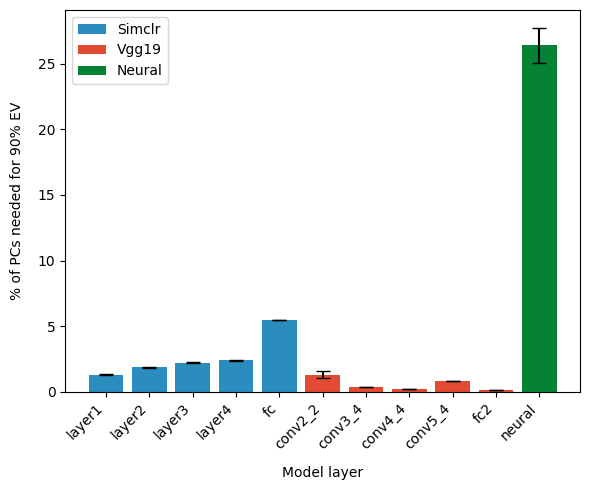

In [8]:
layer_order = [
    'layer1', 'layer2', 'layer3', 'layer4', 'fc',
    'conv2_2', 'conv3_4', 'conv4_4', 'conv5_4', 'fc2'
]
summary['layer'] = pd.Categorical(summary['layer'], categories=layer_order, ordered=True)
summary = summary.sort_values('layer')

model_colour = {
    'simclr': simclr_colours['layer4'],
    'vgg19': vgg19_colours['conv5_4'],
    'neural': neural_colour
}
summary_with_neural['color'] = summary_with_neural['model'].map(model_colour)

summary_with_neural['layer'] = pd.Categorical(
    summary_with_neural['layer'],
    categories=layer_order + ['neural'],
    ordered=True
)
summary_with_neural = summary_with_neural.sort_values('layer')

x_labels = summary_with_neural['layer'].astype(str)
heights = summary_with_neural['mean']
errors = summary_with_neural['sem']
colours = summary_with_neural['color']

plt.figure(figsize=(6, 5))
plt.bar(
    x=x_labels,
    height=heights,
    yerr=errors,
    capsize=5,
    color=colours
)

plt.ylabel('% of PCs needed for 90% EV', labelpad=10)
plt.xlabel('Model layer', labelpad=10)
plt.xticks(rotation=45, ha='right')

# Add legend
plt.legend(
    handles=[
        Patch(facecolor=color, label=label.capitalize())
        for label, color in model_colour.items()
    ]
)

plt.tight_layout()
plt.savefig("./figures/explained-variance-bar-68pc.svg", format='svg')
plt.show()